In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Image examples

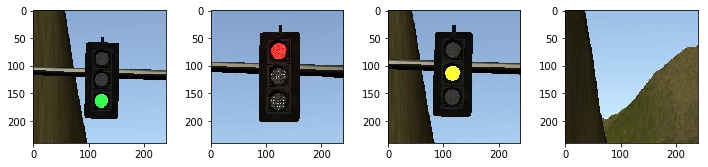

In [19]:
import glob

images = glob.glob('./training_data_simulator/test_cases/*-cut.jpg')

idx = 0
f, ax = plt.subplots(1,4, figsize=(10, 4))
f.tight_layout()

for fname in images:
    img = cv2.imread(fname)
    ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    idx += 1

plt.show()

# Use HSV color space

Traffic light has following properties that can simplify detection:
- It has high intensity (160..255)
- It has high saturation(160..250)
- Ih has one of three possible hue values:
    - Red - -20 to 20  on scale 0 to 360
    - Yellow - around 40 to 80
    - Green - around 108 to 148



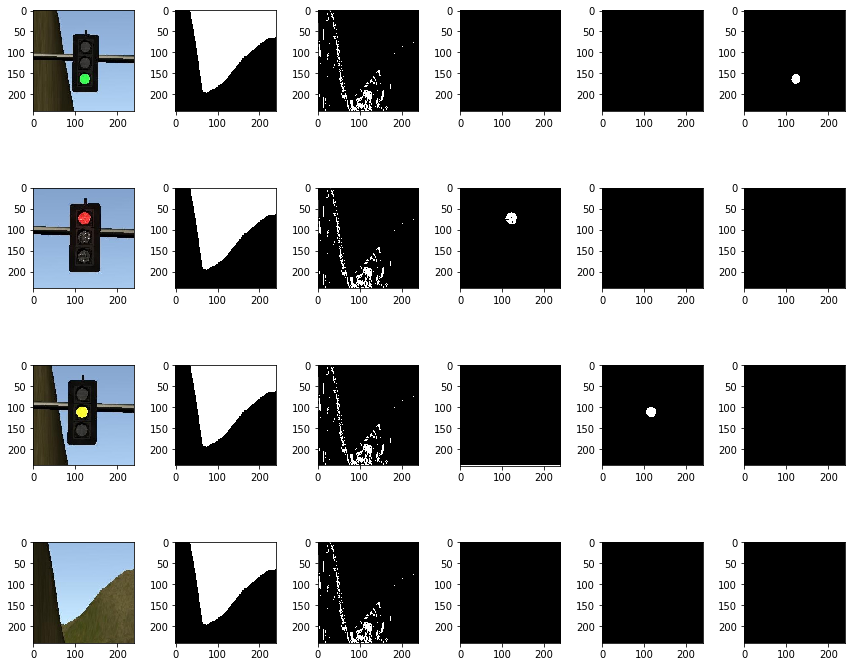

In [73]:
def get_is_mask(s_channel, v_channel):
    intensity_mask = cv2.inRange(v_channel, 160, 255)
    saturation_mask = cv2.inRange(s_channel, 160, 255)
    return intensity_mask & saturation_mask

def get_red_mask(h_channel):
    red_lower_mask = cv2.inRange(h_channel, 0, 10)
    red_upper_mask = cv2.inRange(h_channel, 170, 180)
    return red_lower_mask | red_upper_mask

def get_yellow_mask(h_channel):
    mask = cv2.inRange(h_channel, 20, 40)
    return mask

def get_green_mask(h_channel):
    mask = cv2.inRange(h_channel, 55, 75)
    return mask


idx = 0
f, ax = plt.subplots(4,6, figsize=(12, 10))
f.tight_layout()

for fname in images:
    img = cv2.imread(fname)
    ax[idx, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = hsv_img[:,:,0]
    s = hsv_img[:,:,1]
    v = hsv_img[:,:,2]
    
    is_mask = get_is_mask(s,v)
    red_mask = get_red_mask(h)
    yellow_mask = get_yellow_mask(h)
    green_mask = get_green_mask(h)
        
    ax[idx, 1].imshow(intensity_mask,  cmap='gray')
    ax[idx, 2].imshow(saturation_mask,  cmap='gray')
    ax[idx, 3].imshow(red_mask & is_mask,  cmap='gray')
    ax[idx, 4].imshow(yellow_mask & is_mask,  cmap='gray')
    ax[idx, 5].imshow(green_mask & is_mask,  cmap='gray')
    
    idx += 1

plt.show()

# Use Hough Circle Transform to detect circles

The range filtering above works pretty well for clean simulator images. In real condistions there can be a lot of nose because of other colored objects, reflections, etc. Do be sure we are detecting a traffic light we need aditionally check if masked pixels have form of one or several circles.

OpenCV documentation: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html

None None [[[123.5 162.5  10. ]]]
[[[126.5  147.5    3.35]]] None None
[[[123.5  71.5  11.8]]] None None
None [[[115.5 113.5  11.8]]] None
None None None


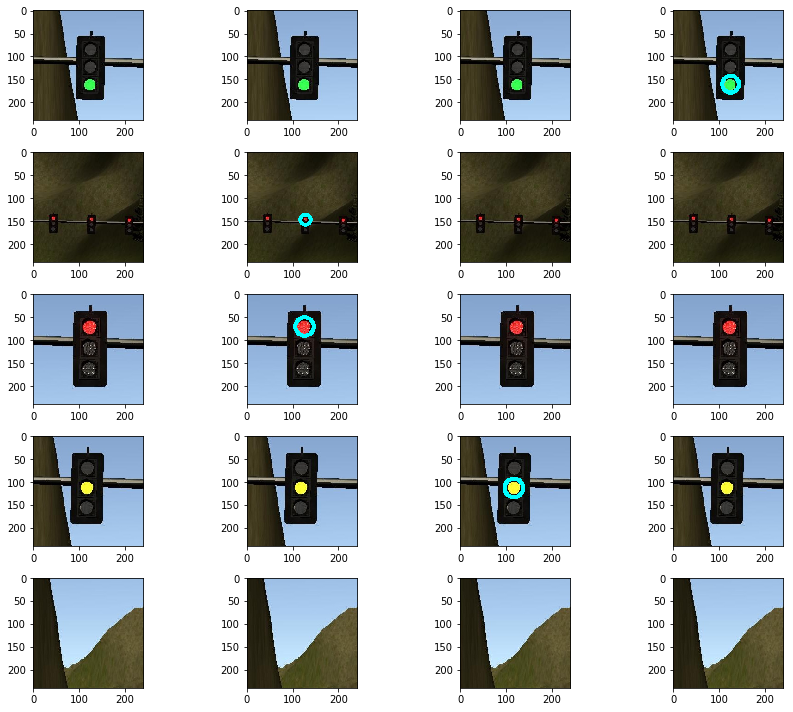

In [110]:
def find_circles(bw_image):
    img = cv2.GaussianBlur(bw_image, (5, 5), 0)
    min_radius = 3 #  bw_image.shape[0] / 200
    max_radius = 20 # bw_image.shape[0] / 30
    min_distance = min_radius * 6
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT,
                               1,
                               minDist = int(min_distance),
                               param1=50,
                               param2=7,
                               minRadius=int(min_radius),
                               maxRadius=int(max_radius))
    return circles

def find_red(hsv):
    red_lower_mask = cv2.inRange(hsv, (0,160,160), (10,255,255))
    red_upper_mask = cv2.inRange(hsv, (170,160,160), (180,255,255))
    mask = red_lower_mask | red_upper_mask
    circles = find_circles(mask)
    return circles, mask

def find_yellow(hsv):
    mask = cv2.inRange(hsv, (20,160,160), (40, 255,255))
    circles = find_circles(mask)
    return circles, mask

def find_green(hsv):
    mask = cv2.inRange(hsv, (55,160,160), (75, 255,255))
    circles = find_circles(mask)
    return circles, mask

def show_circles(circles, image):
    result = np.copy(image)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            if i[2] > 1:
                cv2.circle(result,(i[0],i[1]),i[2] + 8,(255,255,0), 8)
    return result

idx = 0
f, ax = plt.subplots(5,4, figsize=(12, 10))
f.tight_layout()

images = glob.glob('./training_data_simulator/test_cases/*-cut.jpg')

for fname in images:
    img = cv2.imread(fname)
    ax[idx, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    rc,rm = find_red(hsv_img)
    yc,ym = find_yellow(hsv_img)
    gc,gm = find_green(hsv_img)
    
    print(rc, yc,gc)
    
    ax[idx, 1].imshow(cv2.cvtColor(show_circles(rc, img), cv2.COLOR_BGR2RGB))
    ax[idx, 2].imshow(cv2.cvtColor(show_circles(yc, img), cv2.COLOR_BGR2RGB))
    ax[idx, 3].imshow(cv2.cvtColor(show_circles(gc, img), cv2.COLOR_BGR2RGB))
    #ax[idx, 1].imshow(rm, cmap='gray')
    #ax[idx, 2].imshow(ym, cmap='gray')
    #ax[idx, 3].imshow(gm, cmap='gray')
    idx += 1

plt.show()